In [1]:
%reset
from keras import backend as K
K.clear_session()

Nothing done.


In [2]:
!pip install seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 15.8 MB/s eta 0:00:00
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
import pickle
X = pickle.load(open(os.path.join("/datasets/music","acid_vs_hard.pkl"), "rb"))
titles = pd.Series(X[1])
X = X[0]

In [81]:
X = X[:,:,:,[0,1,2]]

In [82]:
y = np.hstack([np.ones(len(X)//2),np.zeros(len(X)//2)]).astype(int)

In [83]:
i_range = np.arange(y.shape[0])

In [84]:
X.shape

(300, 84, 646, 3)

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, i_range, test_size=0.2, random_state=420, stratify=y)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240, 84, 646, 3), (60, 84, 646, 3), (240,), (60,))

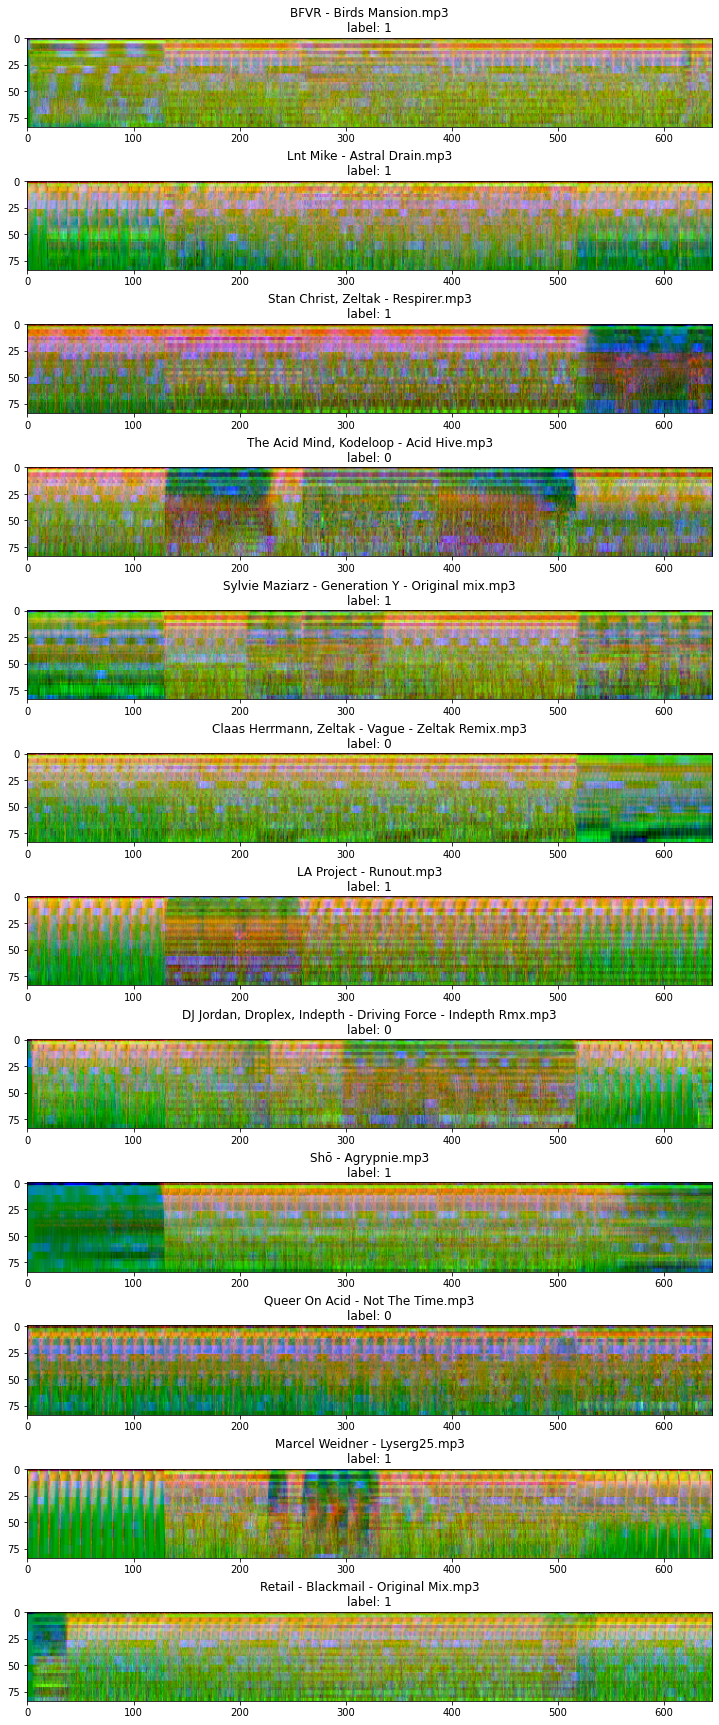

In [87]:
images = np.random.choice(range(X.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(12, 24))
for i in range(1, 13):
    plt.subplot(12, 1, i)
    plt.imshow(X[images[i-1]])
    plt.title(f"{titles[images[i-1]]}\nlabel: {y[images[i-1]]}")
plt.tight_layout()
plt.show()

In [88]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_train.shape[3])

In [89]:
X_train.shape[1:]

(84, 646, 3)

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau

def lenet5():
    model = Sequential()
    # RESIZE
    model.add(BatchNormalization(input_shape=(X_train.shape[1:]), momentum=0.99))
    # CONV POOL 1
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # CONV POOL 2
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # CONV POOL 3
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # DROPOUT AVANT LE FLATTEN
    model.add(Dropout(0.1))
    model.add(Flatten())
    # DENSE 1
    model.add(Dense(units=256, activation='relu'))
    # DENSE 2 DROPOUTtu sais quand 
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    # DENSE 3 DROPOUT
    model.add(Dense(units=64, activation='relu'))
    # Output layer
    model.add(Dense(units=1, activation = 'sigmoid'))
    return model

my_model = lenet5()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_path = 'mdl_wts.hdf5'

mcp_save = ModelCheckpoint(
    checkpoint_path, 
    save_best_only=True, 
    monitor='val_accuracy', 
    mode='max')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.2, 
    patience=3, 
    verbose=1,
    mode='max')
tensor_board = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=True)
callbacks = [mcp_save, reduce_lr_loss]
my_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_51 (Bat  (None, 84, 646, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_51 (Conv2D)          (None, 82, 644, 16)       448       
                                                                 
 batch_normalization_52 (Bat  (None, 82, 644, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 41, 322, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 39, 320, 32)       4640      
                                                     

In [110]:
BATCH_SIZE = 32

my_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE, 
    epochs=150, 
    callbacks=callbacks)

Epoch 1/150
8/8 [==============================] - 2s 151ms/step - loss: 6.8439 - accuracy: 0.5083 - val_loss: 2.0025 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/150
8/8 [==============================] - 0s 29ms/step - loss: 1.2750 - accuracy: 0.5083 - val_loss: 0.6908 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/150
8/8 [==============================] - 1s 142ms/step - loss: 0.8460 - accuracy: 0.5792 - val_loss: 0.6926 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 4/150
8/8 [==============================] - 0s 28ms/step - loss: 0.6553 - accuracy: 0.6167 - val_loss: 0.6928 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/150
8/8 [==============================] - 0s 30ms/step - loss: 0.5823 - accuracy: 0.7750 - val_loss: 0.6930 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/150
6/8 [=====================>........] - ETA: 0s - loss: 0.5386 - accuracy: 0.8177
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
8/8 [==============================] - 0s 28ms/step - loss:

In [111]:
my_model.load_weights(checkpoint_path)

In [113]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = my_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1,0).reshape(y_pred.shape[0])

loss, metric = my_model.evaluate(X_test, y_test, verbose=0)

print('loss is:', loss)
print('accu is:', metric)
print("f1_score is:",f1_score(y_test, y_pred))

loss is: 0.5678967833518982
accu is: 0.7333333492279053
f1_score is: 0.7333333333333333


[]

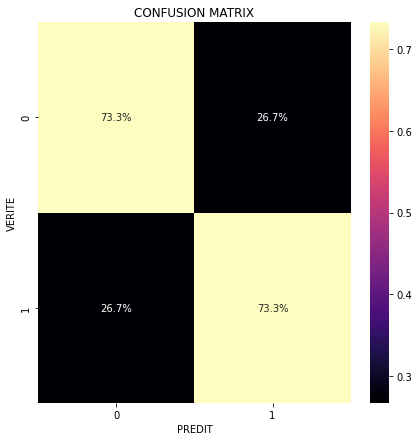

In [114]:
conf = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(7,7))
heat = sns.heatmap(conf, annot=True, cmap="magma", fmt = ".1%")
heat.set(xlabel="PREDIT", ylabel="VERITE", title="CONFUSION MATRIX")
plt.plot()

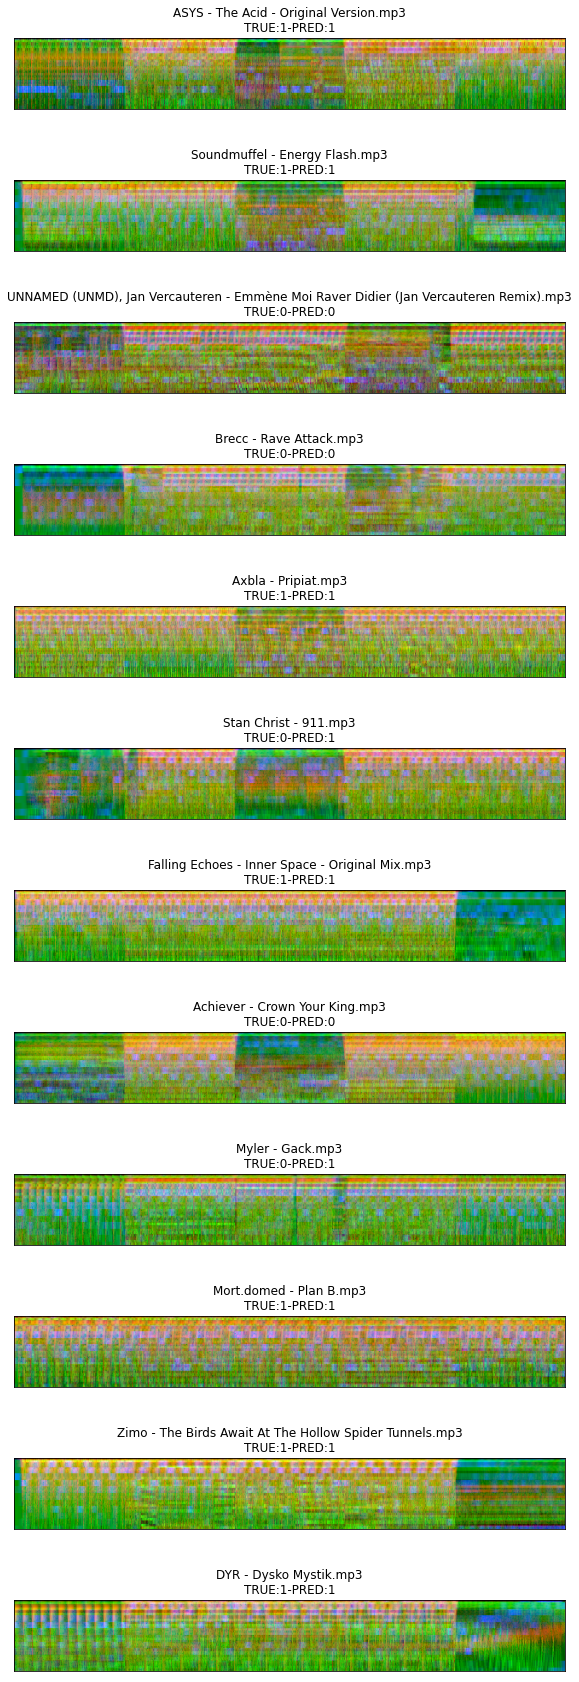

In [115]:
images = np.random.choice(range(X_test.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(8,24))
for i in range(1, 13):
    plt.subplot(12, 1, i)
    fig = plt.imshow(X_test[images[i-1]])
    plt.title(f"{titles[i_test[images[i-1]]]}\nTRUE:{y_test[images[i-1]]}-PRED:{y_pred[images[i-1]]}")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()